dont need to normalise the varibales 

## Model Creation: 

In [1]:
#import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

import re

# Statistics
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats

# Sklearn - model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

#Sklearn - linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC

from sklearn.feature_selection import RFE

In [2]:
data = pd.read_csv('Life_Expectancy_clean.csv')
data.head()

,Life_Expectancy,State_FIPS_Code,County_FIPS_Code,Premature_death_raw_value,Poor_or_fair_health_raw_value,Poor_physical_health_days_raw_value,Poor_mental_health_days_raw_value,Low_birthweight_raw_value,Adult_smoking_raw_value,Adult_obesity_raw_value,...,Uninsured_children_raw_value,Other_primary_care_providers_raw_value,Median_household_income_raw_value,Children_eligible_for_free_or_reduced_price_lunch_raw_value,Residential_segregation___non_white/white_raw_value,Homeownership_raw_value,Severe_housing_cost_burden_raw_value,Population_raw_value,County_Ranked_(Yes1/No0),Drinking_water_violations_raw_value
0,72.438750,-1.694237,-0.703354,2.334237,0.585167,0.972298,0.744619,1.185344,1.262168,0.600135,...,-0.542966,-0.303066,-0.110904,0.526556,-0.593029,0.093544,0.719976,-0.353999,0.149924,-0.857549
1,70.426037,-1.694237,-0.686844,2.505048,2.389854,2.887774,1.915747,1.184023,2.510570,0.882490,...,-0.802039,0.220084,-1.719216,1.152966,1.602039,0.173994,-0.089176,-0.334493,0.149924,1.166115
2,75.056297,-1.694237,-0.670334,0.548239,0.430316,0.944534,0.598795,0.020882,1.220460,-0.082221,...,-0.248064,-0.477779,-0.568212,0.575578,-0.215187,0.787929,-0.730263,-0.304624,0.149924,-0.857549
3,77.644415,-1.694237,-0.653824,-0.211277,-0.007011,0.261949,0.311151,-0.090746,0.551838,0.811901,...,-0.932296,-0.799614,0.847341,-0.419564,-0.252510,1.220457,-0.453010,-0.053936,0.149924,-0.857549
4,74.386212,-1.694237,-0.637314,1.031308,1.168960,1.455216,1.086015,0.018399,1.406349,-0.199869,...,-0.360181,-0.272734,-0.276522,0.254347,0.807143,0.142721,-0.782571,-0.334972,0.149924,-0.857549


In [3]:
# County_Ranked_(Yes1/No0) is causing an issue therefore rename:
data.rename(columns={'County_Ranked_(Yes1/No0)': 'County_Ranked'}, inplace=True)

In [4]:
# Drop the  State_FIPS_Code & County_FIPS_Code
data.drop(columns=['State_FIPS_Code', 'County_FIPS_Code'], inplace=True)

## Check Normality of Variables

In [5]:
# X.hist(figsize=(16,30))
# plt.show()

## Train Test Split

In [6]:
X_init = data.drop(columns=['Life_Expectancy'])
y_init = data['Life_Expectancy']

In [7]:
X_init.shape, y_init.shape

((2138, 54), (2138,))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_init, y_init, test_size=1000, random_state=42)

In [9]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1138, 54), (1000, 54), (1138,), (1000,))

In [10]:
X = X_train
y = y_train

In [11]:
df_model = pd.concat([y,X], axis=1)
# df_model.head()

# Model 1:

- All variable carried forward from the cleaning

## K-fold / Cross Validation Model

In [12]:
regression = LinearRegression()

crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)
baseline = np.mean(cross_val_score(regression, X, y, scoring='r2', cv=crossvalidation))
print("Inital R^2:", baseline)

Inital R^2: 0.9016229194751528


<b>Observations</b>

- Very High R^2 value -> similar to the stats module value
- Look to reduce variables

## Statsmodule OLS model

In [13]:
X_const = sm.add_constant(X)

model = sm.OLS(y, X_const).fit()
model.summary()

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Life_Expectancy   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     235.9
Date:                Tue, 14 Jan 2020   Prob (F-statistic):               0.00
Time:                        15:21:50   Log-Likelihood:                -1430.3
No. Observations:                1138   AIC:                             2971.
Df Residuals:                    1083   BIC:                             3248.
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
const                                                          77.3887      0.026   2975.538      0.000      77.338      77.440
Premature_death_raw_value                                      -0.4079      0.114     -3.576      0.000      -0.632      -0.184
Poor_or_fair_health_raw_value                                   0.2454      0.121      2.023      0.043       0.007       0.483
Poor_physical_health_days_raw_value                            -0.4889      0.298     -1.643      0.101      -1.073       0.095
Poor_mental_health_days_raw_value                               0.0090      0.183      0.049      0.961      -0.350       0.368
Low_birthweight_raw_value                                      -0.0182      0.046     -0.399      0.690      -0.107       0.071
Adult_smoking_raw_value                                         0.0593      0.072      0.820      0.412      -0.083       0.201
Adult_obesity_raw_value                                        -0.0275      0.044     -0.628      0.530      -0.113       0.058
Food_environment_index_raw_value                               -0.7075      0.517     -1.368      0.172      -1.722       0.307
Physical_inactivity_raw_value                                  -0.0217      0.051     -0.425      0.671      -0.122       0.079
Access_to_exercise_opportunities_raw_value                     -0.0189      0.039     -0.490      0.624      -0.095       0.057
Excessive_drinking_raw_value                                   -0.0515      0.050     -1.030      0.303      -0.150       0.047
Alcohol_impaired_driving_deaths_raw_value                       0.0122      0.028      0.432      0.666      -0.043       0.068
Sexually_transmitted_infections_raw_value                       0.0452      0.039      1.172      0.242      -0.031       0.121
Teen_births_raw_value                                           0.0564      0.057      0.983      0.326      -0.056       0.169
Uninsured_raw_value                                             2.1760      0.654      3.327      0.001       0.893       3.460
Primary_care_physicians_raw_value                              -0.0680      0.041     -1.650      0.099      -0.149       0.013
Dentists_raw_value                                              0.0222      0.037      0.607      0.544      -0.050       0.094
Mental_health_providers_raw_value                              -0.0127      0.032     -0.401      0.689      -0.075       0.049
Preventable_hospital_stays_raw_value                           -0.0045      0.034     -0.132      0.895      -0.071       0.062
Mammography_screening_raw_value                                -0.0091      0.040     -0.231      0.817      -0.087       0.068
Flu_vaccina

<b>Observations</b>

- High R^2 value
- High AIC & BIC Values as lots of features

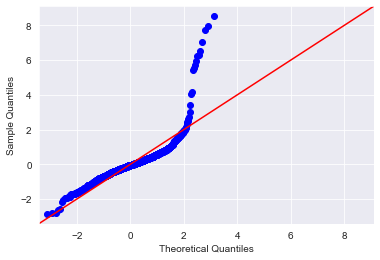

In [14]:
model_qqplot = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

In [15]:
q=0.9

drop_index=y[y > y.quantile(q)].index
X = X.drop(index=drop_index)
y = y[y<=y.quantile(q)]
X_const = sm.add_constant(X)
model_qq = sm.OLS(y, X_const).fit()
model_qq.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Life_Expectancy   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     337.1
Date:                Tue, 14 Jan 2020   Prob (F-statistic):               0.00
Time:                        15:21:59   Log-Likelihood:                -883.57
No. Observations:                1024   AIC:                             1877.
Df Residuals:                     969   BIC:                             2148.
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
const                                                          77.2365      0.019   4028.563      0.000      77.199      77.274
Premature_death_raw_value                                      -0.5020      0.082     -6.110      0.000      -0.663      -0.341
Poor_or_fair_health_raw_value                                   0.1554      0.087      1.779      0.076      -0.016       0.327
Poor_physical_health_days_raw_value                            -0.4482      0.215     -2.086      0.037      -0.870      -0.026
Poor_mental_health_days_raw_value                               0.0072      0.131      0.055      0.956      -0.249       0.264
Low_birthweight_raw_value                                      -0.0149      0.032     -0.462      0.644      -0.078       0.049
Adult_smoking_raw_value                                         0.0319      0.052      0.618      0.536      -0.069       0.133
Adult_obesity_raw_value                                        -0.0644      0.031     -2.070      0.039      -0.125      -0.003
Food_environment_index_raw_value                               -0.6886      0.354     -1.946      0.052      -1.383       0.006
Physical_inactivity_raw_value                                  -0.0396      0.036     -1.093      0.275      -0.111       0.032
Access_to_exercise_opportunities_raw_value                     -0.0317      0.027     -1.163      0.245      -0.085       0.022
Excessive_drinking_raw_value                                    0.0244      0.037      0.652      0.515      -0.049       0.098
Alcohol_impaired_driving_deaths_raw_value                       0.0382      0.021      1.849      0.065      -0.002       0.079
Sexually_transmitted_infections_raw_value                       0.0131      0.027      0.489      0.625      -0.040       0.066
Teen_births_raw_value                                          -0.0833      0.040     -2.060      0.040      -0.163      -0.004
Uninsured_raw_value                                             0.8662      0.471      1.838      0.066      -0.059       1.791
Primary_care_physicians_raw_value                              -0.0982      0.031     -3.146      0.002      -0.159      -0.037
Dentists_raw_value                                              0.0218      0.027      0.792      0.429      -0.032       0.076
Mental_health_providers_raw_value                               0.0018      0.022      0.083      0.934      -0.042       0.045
Preventable_hospital_stays_raw_value                           -0.0243      0.024     -1.001      0.317      -0.072       0.023
Mammography_screening_raw_value                                -0.0096      0.029     -0.337      0.736      -0.066       0.046
Flu_vaccina

<b>Old</b>

Skew:	3.076	
Kurtosis:	23.230

<b>New</b>

Skew:	1.238	
Kurtosis:	11.732	

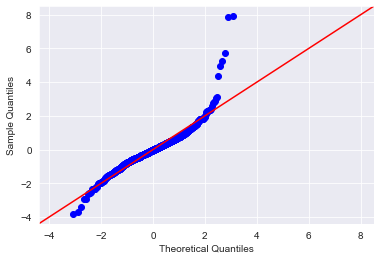

In [16]:
model_qqplot = sm.graphics.qqplot(model_qq.resid, dist=stats.norm, line='45', fit=True)

## Drop Columns on Non-Statistical Evaluation  
<b>Ease of collection</b>
- Has to be a value which is identifiable to the person? i.e Man

<b>Quantifiability</b>
- asd


<b>Cost of Collection</b>
- asdf

In [17]:
X_cols = list(X.columns)
for x in X_cols:
    print(x)

Premature_death_raw_value
Poor_or_fair_health_raw_value
Poor_physical_health_days_raw_value
Poor_mental_health_days_raw_value
Low_birthweight_raw_value
Adult_smoking_raw_value
Adult_obesity_raw_value
Food_environment_index_raw_value
Physical_inactivity_raw_value
Access_to_exercise_opportunities_raw_value
Excessive_drinking_raw_value
Alcohol_impaired_driving_deaths_raw_value
Sexually_transmitted_infections_raw_value
Teen_births_raw_value
Uninsured_raw_value
Primary_care_physicians_raw_value
Dentists_raw_value
Mental_health_providers_raw_value
Preventable_hospital_stays_raw_value
Mammography_screening_raw_value
Flu_vaccinations_raw_value
High_school_graduation_raw_value
Some_college_raw_value
Unemployment_raw_value
Children_in_poverty_raw_value
Income_inequality_raw_value
Children_in_single_parent_households_raw_value
Social_associations_raw_value
Violent_crime_raw_value
Injury_deaths_raw_value
Air_pollution___particulate_matter_raw_value
Severe_housing_problems_raw_value
Driving_alone_t

In [20]:
# # Drop max
# drop = ['Premature_death_raw_value', 
#         'Premature_age_adjusted_mortality_raw_value',
#         'Poor_or_fair_health_raw_value', 
#         'Poor_physical_health_days_raw_value', 
#         'Poor_mental_health_days_raw_value', 
#         'Adult_smoking_raw_value', 
#         'Physical_inactivity_raw_value', 
#         'Excessive_drinking_raw_value',
#         'Preventable_hospital_stays_raw_value', 
#         'Mammography_screening_raw_value', 
#         'Driving_alone_to_work_raw_value',
#         'Long_commute___driving_alone_raw_value', 
#         'Frequent_physical_distress_raw_value', 
#         'Frequent_mental_distress_raw_value',
#         'Insufficient_sleep_raw_value',
#         'Other_primary_care_providers_raw_value',
#         'Drinking_water_violations_raw_value']
# len(drop)

In [21]:
# Drop Hard to measure
drop = ['Premature_age_adjusted_mortality_raw_value', 
        'Premature_death_raw_value', 
        'Poor_or_fair_health_raw_value', 
        'Poor_physical_health_days_raw_value', 
        'Poor_mental_health_days_raw_value']
len(drop)

5

In [22]:
cols = list(X.columns)
new_cols = [x for x in cols if x not in drop]

In [23]:
X_1 = X[new_cols]
len(X.columns) , len(X_1.columns)

(54, 49)

In [24]:
# Run if wish to check all variables
# X_1 = X.copy()

# Model 2:

In [25]:
regression = LinearRegression()

crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)
baseline = np.mean(cross_val_score(regression, X_1, y, scoring='r2', cv=crossvalidation))
print("Inital R^2:", baseline)

Inital R^2: 0.7385141916228726


In [26]:
X_const = sm.add_constant(X_1)

model1 = sm.OLS(y, X_const).fit()
model1.summary()

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Life_Expectancy   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     74.03
Date:                Tue, 14 Jan 2020   Prob (F-statistic):          3.10e-291
Time:                        15:23:00   Log-Likelihood:                -1616.9
No. Observations:                1024   AIC:                             3334.
Df Residuals:                     974   BIC:                             3580.
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
const                                                          77.1774      0.039   1977.631      0.000      77.101      77.254
Low_birthweight_raw_value                                       0.0523      0.064      0.822      0.412      -0.073       0.177
Adult_smoking_raw_value                                        -0.5109      0.098     -5.238      0.000      -0.702      -0.319
Adult_obesity_raw_value                                        -0.0057      0.063     -0.091      0.928      -0.130       0.118
Food_environment_index_raw_value                               -0.4956      0.721     -0.688      0.492      -1.910       0.919
Physical_inactivity_raw_value                                  -0.1023      0.073     -1.404      0.161      -0.245       0.041
Access_to_exercise_opportunities_raw_value                     -0.0413      0.055     -0.745      0.456      -0.150       0.067
Excessive_drinking_raw_value                                    0.0646      0.075      0.859      0.391      -0.083       0.212
Alcohol_impaired_driving_deaths_raw_value                       0.1058      0.042      2.522      0.012       0.023       0.188
Sexually_transmitted_infections_raw_value                      -0.1386      0.054     -2.554      0.011      -0.245      -0.032
Teen_births_raw_value                                          -0.6849      0.079     -8.679      0.000      -0.840      -0.530
Uninsured_raw_value                                             2.5911      0.936      2.767      0.006       0.754       4.428
Primary_care_physicians_raw_value                              -0.0181      0.063     -0.284      0.776      -0.143       0.107
Dentists_raw_value                                              0.0045      0.056      0.080      0.936      -0.105       0.114
Mental_health_providers_raw_value                              -0.0596      0.045     -1.323      0.186      -0.148       0.029
Preventable_hospital_stays_raw_value                           -0.1193      0.049     -2.451      0.014      -0.215      -0.024
Mammography_screening_raw_value                                 0.1292      0.056      2.294      0.022       0.019       0.240
Flu_vaccinations_raw_value                                      0.0023      0.053      0.043      0.966      -0.102       0.107
High_school_graduation_raw_value                               -0.1372      0.048     -2.852      0.004      -0.232      -0.043
Some_college_raw_value                                         -0.1295      0.069     -1.868      0.062      -0.266       0.007
Unemployment_raw_value                                          0.0318      0.064      0.493      0.622      -0.095       0.158
Children_in

In [27]:
# dir(model)

In [28]:
# model.params

## Eliminate Features using the P-value score

In [29]:
def func_rfe(X_1, model):
    X_cols = list(X_1.columns)
    X_cols = ['const'] + X_cols
    rfe = list(zip(X_cols, model.pvalues))
    rfe = pd.DataFrame(rfe, columns=['Parameters', 'P_values'])
    rfe.sort_values(by='P_values', ascending=True, inplace=True)
    rfe_reduced = rfe.loc[rfe['P_values'] < 0.05]
    return rfe_reduced

In [30]:
rfe_reduced = func_rfe(X_1, model1)
rfe_reduced

,Parameters,P_values
0,const,0.000000e+00
26,Injury_deaths_raw_value,2.831789e-36
10,Teen_births_raw_value,1.660167e-17
2,Adult_smoking_raw_value,1.985017e-07
31,Frequent_physical_distress_raw_value,1.826508e-05
32,Frequent_mental_distress_raw_value,2.828100e-03
39,Uninsured_adults_raw_value,3.034904e-03
18,High_school_graduation_raw_value,4.432200e-03
11,Uninsured_raw_value,5.759016e-03
30,Long_commute___driving_alone_raw_value,5.960683e-03


In [31]:
rfe_reduced = rfe_reduced.loc[rfe_reduced['Parameters'] != 'const']
X_cols = list(rfe_reduced.Parameters)
X_2 = X_1[X_cols]
# X_2.sort_index()

# Model 3:

In [32]:
X_const = sm.add_constant(X_2)

model2 = sm.OLS(y, X_const).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Life_Expectancy   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     164.8
Date:                Tue, 14 Jan 2020   Prob (F-statistic):          3.99e-307
Time:                        15:23:38   Log-Likelihood:                -1647.1
No. Observations:                1024   AIC:                             3338.
Df Residuals:                    1002   BIC:                             3447.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
const                                           77.1806      0.039   1972.874      0.000      77.104      77.257
Injury_deaths_raw_value                         -0.7290      0.054    -13.581      0.000      -0.834      -0.624
Teen_births_raw_value                           -0.6031      0.071     -8.516      0.000      -0.742      -0.464
Adult_smoking_raw_value                         -0.4881      0.080     -6.066      0.000      -0.646      -0.330
Frequent_physical_distress_raw_value             0.7826      0.162      4.831      0.000       0.465       1.100
Frequent_mental_distress_raw_value              -0.7123      0.154     -4.638      0.000      -1.014      -0.411
Uninsured_adults_raw_value                      -1.5662      0.399     -3.921      0.000      -2.350      -0.782
High_school_graduation_raw_value                -0.1389      0.045     -3.122      0.002      -0.226      -0.052
Uninsured_raw_value                              1.5923      0.391      4.071      0.000       0.825       2.360
Long_commute___driving_alone_raw_value          -0.0455      0.048     -0.943      0.346      -0.140       0.049
Air_pollution___particulate_matter_raw_value    -0.2100      0.060     -3.481      0.001      -0.328      -0.092
Sexually_transmitted_infections_raw_value       -0.2785      0.045     -6.235      0.000      -0.366      -0.191
Alcohol_impaired_driving_deaths_raw_value        0.1100      0.042      2.639      0.008       0.028       0.192
Motor_vehicle_crash_deaths_raw_value            -0.1640      0.053     -3.086      0.002      -0.268      -0.060
Preventable_hospital_stays_raw_value            -0.1719      0.046     -3.699      0.000      -0.263      -0.081
Population_raw_value                             0.1033      0.049      2.122      0.034       0.008       0.199
Median_household_income_raw_value                0.3365      0.080      4.219      0.000       0.180       0.493
Insufficient_sleep_raw_value                    -0.1647      0.070     -2.347      0.019      -0.302      -0.027
County_Ranked                                    0.1362      0.043      3.179      0.002       0.052       0.220
Mammography_screening_raw_value                  0.1296      0.052      2.513      0.012       0.028       0.231
Driving_alone_to_work_raw_value                 -0.0998      0.052     -1.927      0.054      -0.201       0.002
Diabetes_prevalence_raw_value                   -0.1800      0.067     -2.695      0.007      -0.311      -0.049
==============================================================================
Omnibus:                       67.915   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              279.201
Skew:                

In [33]:
rfe_red2 = func_rfe(X_2, model2)
rfe_red2

,Parameters,P_values
0,const,0.000000e+00
1,Injury_deaths_raw_value,1.092858e-38
2,Teen_births_raw_value,5.963018e-17
11,Sexually_transmitted_infections_raw_value,6.638227e-10
3,Adult_smoking_raw_value,1.855141e-09
4,Frequent_physical_distress_raw_value,1.571283e-06
5,Frequent_mental_distress_raw_value,3.988840e-06
16,Median_household_income_raw_value,2.673513e-05
8,Uninsured_raw_value,5.053476e-05
6,Uninsured_adults_raw_value,9.421483e-05


In [34]:
rfe_red2 = rfe_red2.loc[rfe_red2['Parameters'] != 'const']
X_cols = list(rfe_red2.Parameters)
X_3 = X_2[X_cols]
# X_3.sort_index()

In [35]:
X_const = sm.add_constant(X_3)

model3 = sm.OLS(y, X_const).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Life_Expectancy   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     181.5
Date:                Tue, 14 Jan 2020   Prob (F-statistic):          1.80e-308
Time:                        15:24:47   Log-Likelihood:                -1649.3
No. Observations:                1024   AIC:                             3339.
Df Residuals:                    1004   BIC:                             3437.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
const                                           77.1791      0.039   1972.069      0.000      77.102      77.256
Injury_deaths_raw_value                         -0.7254      0.054    -13.516      0.000      -0.831      -0.620
Teen_births_raw_value                           -0.6113      0.069     -8.900      0.000      -0.746      -0.477
Sexually_transmitted_infections_raw_value       -0.2657      0.044     -6.022      0.000      -0.352      -0.179
Adult_smoking_raw_value                         -0.4770      0.080     -5.937      0.000      -0.635      -0.319
Frequent_physical_distress_raw_value             0.8090      0.162      5.004      0.000       0.492       1.126
Frequent_mental_distress_raw_value              -0.7232      0.154     -4.706      0.000      -1.025      -0.422
Median_household_income_raw_value                0.3135      0.078      4.043      0.000       0.161       0.466
Uninsured_raw_value                              1.7032      0.388      4.394      0.000       0.943       2.464
Uninsured_adults_raw_value                      -1.6808      0.396     -4.249      0.000      -2.457      -0.905
Preventable_hospital_stays_raw_value            -0.1794      0.046     -3.867      0.000      -0.270      -0.088
Air_pollution___particulate_matter_raw_value    -0.2495      0.057     -4.360      0.000      -0.362      -0.137
County_Ranked                                    0.1238      0.042      2.968      0.003       0.042       0.206
High_school_graduation_raw_value                -0.1447      0.044     -3.255      0.001      -0.232      -0.057
Motor_vehicle_crash_deaths_raw_value            -0.1699      0.052     -3.237      0.001      -0.273      -0.067
Diabetes_prevalence_raw_value                   -0.2121      0.063     -3.356      0.001      -0.336      -0.088
Alcohol_impaired_driving_deaths_raw_value        0.1108      0.042      2.657      0.008       0.029       0.193
Mammography_screening_raw_value                  0.1247      0.051      2.438      0.015       0.024       0.225
Insufficient_sleep_raw_value                    -0.1810      0.069     -2.604      0.009      -0.317      -0.045
Population_raw_value                             0.1181      0.048      2.461      0.014       0.024       0.212
==============================================================================
Omnibus:                       63.335   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              248.477
Skew:                          -0.087   Prob(JB):                     1.11e-54
Kurtosis:                       5.407   Cond. No.                         35.8
==============================================================================

Warnings:

# Interactions 

In [36]:
def feature_combinations_r_sqrd_with_Inter_df(X, y, num_feat_comb=2):
    # Requires cals: baseline & crossvalidation
    
    # Create Regression & Combinations
    from itertools import combinations
    combinations = list(combinations(list(X.columns), num_feat_comb))
    
    # Create cross-validation & output a bassline MSE score as a DataFrame
    comb_scores = []
    inter_cols = []
    inter_score = []
    data = X.copy()
    
    for comb in combinations:
        data['interaction'] = data[comb[0]] * data[comb[1]]
        score = np.mean(cross_val_score(regression, data, y, scoring='r2', cv=crossvalidation))
        if score > baseline: 
            comb_scores.append(round(score,3))
            inter_cols.append((str(comb[0]) + '_' + str(comb[1])))
            inter_score.append(data[comb[0]] * data[comb[1]])
    
    df_base = pd.DataFrame(data=[inter_cols, comb_scores])
    df_base = df_base.T  
    df_base.rename(columns={0: "Interaction", 1: "CV_score"}, inplace=True)
    df_base.sort_values(by='CV_score', inplace = True, ascending=False )
    df_base.reset_index(drop=True, inplace = True)
    
    df_interactions_scores = pd.DataFrame(data=inter_score , index=inter_cols)
    df_interactions_scores = df_interactions_scores.T
    

    return df_base , df_interactions_scores

In [37]:
regression = LinearRegression()

crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)
baseline = np.mean(cross_val_score(regression, X_3, y, scoring='r2', cv=crossvalidation))
print("Inital R^2:", baseline)

Inital R^2: 0.7536925509596395


In [38]:
df_base, df_score = feature_combinations_r_sqrd_with_Inter_df(X_3,y)

In [39]:
df_base.head(10)

,Interaction,CV_score
0,Frequent_mental_distress_raw_value_County_Ranked,0.763
1,Frequent_physical_distress_raw_value_County_Ra...,0.763
2,County_Ranked_Insufficient_sleep_raw_value,0.763
3,Injury_deaths_raw_value_County_Ranked,0.763
4,Adult_smoking_raw_value_County_Ranked,0.762
5,Injury_deaths_raw_value_Air_pollution___partic...,0.76
6,Teen_births_raw_value_Uninsured_raw_value,0.758
7,Teen_births_raw_value_Uninsured_adults_raw_value,0.758
8,County_Ranked_Mammography_screening_raw_value,0.757
9,Median_household_income_raw_value_County_Ranked,0.757


In [40]:
def add_interaction_feature(data, df_inter, df_score, num_inter):
    i=0
    
    while i < num_inter:
        col = df_inter['Interaction'][i]
  
        data[col] = df_score[col]
        i+=1
    
    return data

In [41]:
data_combined = add_interaction_feature(X_3, df_base, df_score, 7)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [42]:
data_combined.head()

,Injury_deaths_raw_value,Teen_births_raw_value,Sexually_transmitted_infections_raw_value,Adult_smoking_raw_value,Frequent_physical_distress_raw_value,Frequent_mental_distress_raw_value,Median_household_income_raw_value,Uninsured_raw_value,Uninsured_adults_raw_value,Preventable_hospital_stays_raw_value,...,Mammography_screening_raw_value,Insufficient_sleep_raw_value,Population_raw_value,Frequent_mental_distress_raw_value_County_Ranked,Frequent_physical_distress_raw_value_County_Ranked,County_Ranked_Insufficient_sleep_raw_value,Injury_deaths_raw_value_County_Ranked,Adult_smoking_raw_value_County_Ranked,Injury_deaths_raw_value_Air_pollution___particulate_matter_raw_value,Teen_births_raw_value_Uninsured_raw_value
813,-0.312067,0.626203,1.565672,-0.130554,1.209439,0.886447,-0.960806,0.121788,0.095718,0.771757,...,-1.290252,-0.552999,-0.309893,0.132900,0.181324,-0.082908,-0.046786,-0.019573,0.309465,0.076264
1604,-0.495003,0.023160,0.425137,-1.298671,-0.648396,-0.769789,0.545436,2.449321,1.961372,-1.580588,...,0.624173,-0.975162,-0.277381,-0.115410,-0.097210,-0.146200,-0.074213,-0.194702,0.087845,0.056727
406,0.430561,0.430465,-0.338264,0.459604,0.691916,0.691848,-0.975835,0.485992,0.623742,0.293664,...,-1.034995,-0.151571,-0.353953,0.103725,0.103735,-0.022724,0.064552,0.068906,0.250783,0.209203
1211,2.772400,-0.521567,-0.832906,-0.829082,-0.133820,0.227456,-0.755572,-0.489671,-0.569138,-1.295690,...,-0.907367,-0.890020,-0.293960,0.034101,-0.020063,-0.133436,0.415650,-0.124299,-1.093943,0.255396
1089,0.559720,1.070560,0.481905,1.843320,0.285993,0.477604,-0.327301,-0.967011,-0.956897,1.248821,...,0.113660,1.236672,-0.117630,0.071604,0.042877,0.185407,0.083916,0.276358,0.872880,-1.035243


# Polynomial Parameters

In [43]:
# from sklearn.preprocessing import PolynomialFeatures

# regression = LinearRegression()
# crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)

# polynomials = []
# for col in X.columns:
#     for degree in [2, 3, 4]:
#         data = X.copy()
#         poly = PolynomialFeatures(degree, include_bias=False)
#         X_transformed = poly.fit_transform(X[[col]])
#         data = pd.concat([data.drop(col, axis=1),pd.DataFrame(X_transformed)], axis=1)
#         score = np.mean(cross_val_score(regression, data, y, scoring='r2', cv=crossvalidation))
#         if score > baseline: polynomials.append((col, degree, round(score, 3)))
# print('Top 10 polynomials: %s' %sorted(polynomials, key=lambda poly: poly[2], reverse=True)[:10])

In [44]:
# polynom = pd.DataFrame(polynomials)
# polynom.groupby([0], sort=False)[2].max()

# Full model R-squared  

In [45]:
full_model = np.mean(cross_val_score(regression, data_combined, y, scoring='r2', cv=crossvalidation))
print("Full model R^2:", full_model)

Full model R^2: -5.65289611921203e+26


In [46]:
X_const = sm.add_constant(data_combined)

model = sm.OLS(y, X_const).fit()
model.summary()

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Life_Expectancy   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     145.7
Date:                Tue, 14 Jan 2020   Prob (F-statistic):          9.35e-318
Time:                        15:25:40   Log-Likelihood:                -1608.8
No. Observations:                1024   AIC:                             3272.
Df Residuals:                     997   BIC:                             3405.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
========================================================================================================================================
                                                                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------
const                                                                   77.1128      0.045   1701.459      0.000      77.024      77.202
Injury_deaths_raw_value                                                 -0.8583      0.056    -15.207      0.000      -0.969      -0.748
Teen_births_raw_value                                                   -0.6043      0.069     -8.779      0.000      -0.739      -0.469
Sexually_transmitted_infections_raw_value                               -0.2880      0.044     -6.543      0.000      -0.374      -0.202
Adult_smoking_raw_value                                                 -0.5159      0.079     -6.520      0.000      -0.671      -0.361
Frequent_physical_distress_raw_value                                     0.7534      0.159      4.746      0.000       0.442       1.065
Frequent_mental_distress_raw_value                                      -0.6756      0.151     -4.467      0.000      -0.972      -0.379
Median_household_income_raw_value                                        0.2158      0.076      2.823      0.005       0.066       0.366
Uninsured_raw_value                                                      1.9697      0.395      4.990      0.000       1.195       2.744
Uninsured_adults_raw_value                                              -2.0885      0.408     -5.125      0.000      -2.888      -1.289
Preventable_hospital_stays_raw_value                                    -0.1675      0.045     -3.714      0.000      -0.256      -0.079
Air_pollution___particulate_matter_raw_value                            -0.1900      0.057     -3.349      0.001      -0.301      -0.079
County_Ranked                                                           -0.0580      0.090     -0.647      0.518      -0.234       0.118
High_school_graduation_raw_value                                        -0.1287      0.044     -2.919      0.004      -0.215      -0.042
Motor_vehicle_crash_deaths_raw_value                                    -0.1383      0.051     -2.706      0.007      -0.239      -0.038
Diabetes_prevalence_raw_value                                           -0.1216      0.062     -1.952      0.051      -0.244       0.001
Alcohol_impaired_driving_deaths_raw_value                                0.1366      0.040      3.372      0.001       0.057       0.216
Mammography_screening_raw_value                                          0.1269      0.050      2.561      0.011       0.030       0.224
Insufficient_sleep_raw_value                                            -0.2084      0.068     -3.067      0.002      -0.342      -0.075
Population_raw_value                                                 

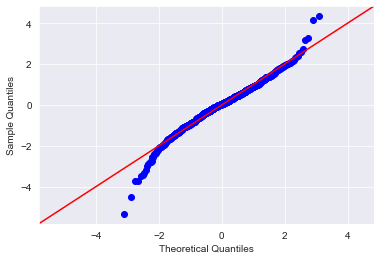

In [47]:
model_qqplot = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

# Lasso

In [50]:
X = data_combined

In [51]:
# from sklearn.linear_model import Lasso

In [52]:
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


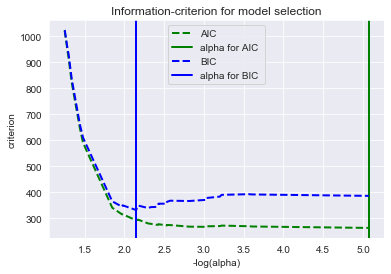

In [53]:
# Your code here - answers

model_bic = LassoLarsIC(criterion='bic')
model_bic.fit(X, y)
alpha_bic_ = model_bic.alpha_

model_aic = LassoLarsIC(criterion='aic')
model_aic.fit(X, y)
alpha_aic_ = model_aic.alpha_


def plot_ic_criterion(model, name, color):
    alpha_ = model.alpha_
    alphas_ = model.alphas_
    criterion_ = model.criterion_
    plt.plot(-np.log10(alphas_), criterion_, '--', color=color, linewidth=2, label= name)
    plt.axvline(-np.log10(alpha_), color=color, linewidth=2,
                label='alpha for %s ' % name)
    plt.xlabel('-log(alpha)')
    plt.ylabel('criterion')

plt.figure()
plot_ic_criterion(model_aic, 'AIC', 'green')
plot_ic_criterion(model_bic, 'BIC', 'blue')
plt.legend()
plt.title('Information-criterion for model selection');

## Lasso paths

In [ ]:
from itertools import cycle
from sklearn.linear_model import lasso_path, enet_path

In [ ]:
# Compute paths
def comp_lasso_paths(X,y, eps=5e-3):
    eps = eps  # path length (Smaller = Longer)

    print("Computing regularization path using the lasso...")
    alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps, fit_intercept=False)
    
    print("Computing regularization path using the positive lasso...")
    alphas_positive_lasso, coefs_positive_lasso, _ = lasso_path(
        X, y, eps, positive=True, fit_intercept=False)
    print("Computing regularization path using the elastic net...")
    alphas_enet, coefs_enet, _ = enet_path(
        X, y, eps=eps, l1_ratio=0.8, fit_intercept=False)

    print("Computing regularization path using the positive elastic net...")
    alphas_positive_enet, coefs_positive_enet, _ = enet_path(
        X, y, eps=eps, l1_ratio=0.8, positive=True, fit_intercept=False)
    
    # Display results

    plt.figure(1)
    colors = cycle(['b', 'r', 'g', 'c', 'k'])
    neg_log_alphas_lasso = -np.log10(alphas_lasso)
    neg_log_alphas_enet = -np.log10(alphas_enet)
    for coef_l, coef_e, c in zip(coefs_lasso, coefs_enet, colors):
        l1 = plt.plot(neg_log_alphas_lasso, coef_l, c=c)
        l2 = plt.plot(neg_log_alphas_enet, coef_e, linestyle='--', c=c)

    plt.xlabel('-Log(alpha)')
    plt.ylabel('coefficients')
    plt.title('Lasso and Elastic-Net Paths')
    plt.legend((l1[-1], l2[-1]), ('Lasso', 'Elastic-Net'), loc='lower left')
    plt.axis('tight')


    plt.figure(2)
    neg_log_alphas_positive_lasso = -np.log10(alphas_positive_lasso)
    for coef_l, coef_pl, c in zip(coefs_lasso, coefs_positive_lasso, colors):
        l1 = plt.plot(neg_log_alphas_lasso, coef_l, c=c)
        l2 = plt.plot(neg_log_alphas_positive_lasso, coef_pl, linestyle='--', c=c)

    plt.xlabel('-Log(alpha)')
    plt.ylabel('coefficients')
    plt.title('Lasso and positive Lasso')
    plt.legend((l1[-1], l2[-1]), ('Lasso', 'positive Lasso'), loc='lower left')
    plt.axis('tight')


    plt.figure(3)
    neg_log_alphas_positive_enet = -np.log10(alphas_positive_enet)
    for (coef_e, coef_pe, c) in zip(coefs_enet, coefs_positive_enet, colors):
        l1 = plt.plot(neg_log_alphas_enet, coef_e, c=c)
        l2 = plt.plot(neg_log_alphas_positive_enet, coef_pe, linestyle='--', c=c)

    plt.xlabel('-Log(alpha)')
    plt.ylabel('coefficients')
    plt.title('Elastic-Net and positive Elastic-Net')
    plt.legend((l1[-1], l2[-1]), ('Elastic-Net', 'positive Elastic-Net'),
               loc='lower left')
    plt.axis('tight')
    plt.show()
    
    return None

In [ ]:
comp_lasso_paths(X_3, y, eps=5e-3)

In [ ]:
x

# ZZ -  Feature ranking to recursive eliminate features

In [ ]:
# df_feat_rank = pd.concat([y,X_1], axis=1)
# df_feat_rank.head()

In [ ]:
linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select=20) # 20 most important features
selector = selector.fit(X_1, y)
estimators = selector.estimator_

In [ ]:
# print(selector.support_ )
# print(selector.ranking_)
# print(estimators.coef_)
# print(estimators.intercept_)
print(selector.classes_)

In [ ]:
# dir(selector)

In [ ]:
X_cols = list(X_1.columns)
X_best = []
i=0
for x in selector.support_:
    if x == True:
        X_best.append((X_cols[i], selector.ranking_[i]))
    i+=1

In [ ]:
# X_best

In [ ]:
sell = list(zip(X_cols, estimators.coef_, selector.ranking_, selector.support_))
df_selection = pd.DataFrame(sell, columns=['X_cols', 'coef','ranking', 'support'])
df_selection.sort_values(by=['ranking'], inplace=True)
df_selection.head(30)

In [ ]:
corr = X_1.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, 
           center=True)